# Flower Species Recognition and Image Classification Analysis

Date: 12/03/2025

Team Members:
- Karrie Butcher
- Nicko Lomelin
- Thanh Tuan Pham

dataset: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition 

The dataset is designed for classifying the specific species of flowers (labeled as 'daisy', 'dandelion', 'rose', 'sunflower', or 'tulip') based on unstructured visual data, specifically, raw RGB pixel intensities representing shapes, textures, and color patterns. The primary business value of building a predictive model on this data is to enable automated botanical identification. In an agricultural or gardening context, an accurate model allows for the development of "intelligent" robotic systems capable of distinguishing between decorative plants (e.g., Tulips/Roses) and invasive species or weeds (e.g., Dandelions). This distinction allows for targeted automated weeding, reducing the need for blanket herbicide application, or  educational apps that allow users to instantly identify flora in their environment.

Prediction Task: **Multi-Class Image Classification**

We will build a Convolutional Neural Network (CNN) to predict the flower_class (the target variable) as one of five distinct species categories based on the input image tensor.

---
## 1. Preparation

****
### **1.1 Chosen Metric(s) and Justification**

#### Chosen Metrics: **Macro-Averaged F1-Score** and **Confusion Matrix**

#### Justification: 

We will use the **Macro-Averaged F1-Score** as our primary metric to mathematically balance the cost of accidentally spraying crops (Precision) against the cost of missing weeds (Recall), while utilizing a **Confusion Matrix** to diagnose specific inter-class errors.

**Why Accuracy is Insufficient:**
We cannot rely on simple Accuracy for this task due to the class imbalance in the dataset (e.g., *Dandelion* has ~1,052 images while *Sunflower* has only ~733). A model could achieve high accuracy by identifying the majority class (Dandelions) while failing completely on the minority classes. This is unacceptable for our objective.

**Why F1-Score (Macro) is Appropriate:**
The F1-Score is the harmonic mean of Precision and Recall. In our proposed business case of **Automated Weeding**, both types of errors carry significant, distinct costs:

* **Precision (Cost of False Positives):** If our model falsely classifies a decorative *Rose* as a weed (*Dandelion*), the automated system might spray herbicide on it, destroying a valuable crop. High precision is required to prevent this economic loss.
* **Recall (Cost of False Negatives):** If our model fails to identify a *Dandelion* (classifying it as a *Rose*), the weed remains and competes for nutrients, reducing yield. High recall is required to ensure effectiveness.

We specifically select the **Macro-Average** (calculating F1 for each class independently and then averaging) rather than the Weighted-Average. This ensures that the model's performance on rarer flowers (like Sunflowers) is treated as equally important to its performance on abundant weeds.

**Why Confusion Matrix:**
Finally, we will visualize the results using a Confusion Matrix. This allows us to look "under the hood" to see exactly which pairs of flowers are being confused (e.g., are we consistently confusing *Tulips* with *Roses*?), allowing us to diagnose if specific visual features (like color or shape) are causing model failure.


***

### **1.2 Chosen Method for Dividing Data and Justification**

#### Chosen Method: Stratified Shuffle Split (80% Training / 20% Testing)

#### Justification:

We will use a **Stratified Shuffle Split**, allocating 80% of the data for training and 20% for final testing. During the model training phase (the 80% split), we will further reserve a portion (e.g., 10%) as a **validation set** to monitor convergence and prevent overfitting.

**Why Stratified?**
Our dataset is imbalanced (e.g., the *Sunflower* class makes up only ~17% of the data, while *Dandelion* is ~24%). A simple random shuffle runs the risk of creating a Test Set that has disproportionately few Sunflowers. If our Test Set does not contain a representative number of all species, our evaluation will be statistically unreliable. Stratified splitting forces the Train and Test sets to preserve the **exact same percentage** of each flower class as the original full dataset.

**Why not 10-Fold Cross-Validation?**
While 10-Fold Cross-Validation is standard for lighter algorithms (like SVMs or Decision Trees), it is computationally prohibitive for Convolutional Neural Networks (CNNs) due to the high training time required for image data.

**Realistic Mirroring:**
This stratified approach mirrors real-world deployment (the "Business Case"). In the field, an automated weeding robot will encounter flowers in their natural frequencies (i.e., more weeds than decorative flowers). By ensuring our Test set maintains this natural distribution, we can be confident that our metrics reflect how the model will actually perform in the agricultural environment, rather than being an artifact of a skewed random data split.

# 2. Modeling

In [8]:
# ==========================================================
# SECTION 1 — Data Loading, Resizing, Splitting, Augmentation
# ==========================================================

import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

# ----------------------------------------------------------
# 1. BUILD UNIVERSAL DATASET PATH (WORKS FOR ANY USER)
# ----------------------------------------------------------
home = os.path.expanduser("~")   # Automatically detects user's home directory

data_dir = os.path.join(
    home, "Downloads", "Flowers Recognition", "flowers"
)



# ----------------------------------------------------------
# 2. LOAD DATASET WITH FORCED RESIZING (CRITICAL)
# ----------------------------------------------------------
image_size = (128, 128)
batch_size = 32

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    image_size=image_size,      # <-- REQUIRED so CNN NEVER crashes
    shuffle=True
)

# ----------------------------------------------------------
# 3. EXTRACT RAW ARRAYS FOR STRATIFIED SPLITTING
# ----------------------------------------------------------
X = []
y = []

for images, labels in dataset:
    X.append(images.numpy())
    y.append(labels.numpy())

X = np.concatenate(X)
y = np.concatenate(y)

print("Loaded images:", X.shape)
print("Loaded labels:", y.shape)

# Normalize pixel values (0–1)
X = X / 255.0

# ----------------------------------------------------------
# 4. STRATIFIED 80/20 TRAIN–TEST SPLIT
# ----------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

num_classes = len(np.unique(y))
print("Detected classes:", num_classes)

# ----------------------------------------------------------
# 5. PREPARE ONE-HOT LABELS FOR MULTI-CLASS ROC/AUC
# ----------------------------------------------------------
y_test_1hot = label_binarize(y_test, classes=list(range(num_classes)))

# ----------------------------------------------------------
# 6. DATA AUGMENTATION LAYERS 
# ----------------------------------------------------------
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),   # robot sees flowers from left/right
    tf.keras.layers.RandomRotation(0.2),        # different approach angles
    tf.keras.layers.RandomZoom(0.2),            # camera distance changes
    tf.keras.layers.RandomContrast(0.2),        # outdoor lighting variations
])




Found 4317 files belonging to 5 classes.


Found 4317 files belonging to 5 classes.


2025-12-02 17:13:15.571456: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 4317 files belonging to 5 classes.


2025-12-02 17:13:15.571456: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loaded images: (4317, 128, 128, 3)
Loaded labels: (4317,)
Detected classes: 5
Detected classes: 5


To make my training process more realistic and prevent overfitting, I used Keras data augmentation layers during preprocessing. The flowers in the dataset come from different angles, distances, and lighting conditions, so I picked augmentation techniques that mimic these natural variations. I applied horizontal flipping, random rotation, random zoom, and random contrast. These transformations make sense for our business case because the weeding robot might see a flower from the left or right, be positioned slightly closer or farther away, or operate under inconsistent outdoor lighting. By exposing the CNN to these variations during training, the model becomes more robust and better prepared for real-world scenarios. Overall, the data augmentation setup helped diversify the training examples without needing more data, which improved the model’s generalization.

For the CNN Models, I built and trained four different convolutional neural network models: two architectures with two variations each. Architecture A was a simple two-block CNN, while Architecture B was a deeper model with three convolutional blocks. For each architecture, I changed the number of filters to see how model capacity affected performance. All models were trained on 128×128 resized images, using a stratified 80/20 split and Macro-F1 as the main metric. I also tracked both training and validation performance using Keras’ history object to make sure the models converged. Across the board, all four CNNs showed stable training curves, with validation accuracy and loss behaving as expected. This experiment helped me clearly see how deeper architectures extract richer spatial features and how adjusting filter sizes impacts the model’s ability to learn meaningful patterns.

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np


In [10]:
def build_cnn_A(filters1=32, filters2=64):
    model = models.Sequential([
        data_augmentation,   # augmentation from section 1
        
        layers.Conv2D(filters1, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Conv2D(filters2, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [11]:
def build_cnn_B(filters1=32, filters2=64, filters3=128):
    model = models.Sequential([
        data_augmentation,

        layers.Conv2D(filters1, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Conv2D(filters2, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Conv2D(filters3, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),

        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [12]:
def train_and_plot(model, model_name):
    print(f"\n Training {model_name} ...")

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=10,
        batch_size=32,
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(10,4))

    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()

    plt.show()

    # Predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # F1 Score
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"\n {model_name} — Macro F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    return f1



 Training CNN A — 32/64 Filters ...
Epoch 1/10
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.4422 - loss: 1.3317 - val_accuracy: 0.5723 - val_loss: 1.0639
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.4422 - loss: 1.3317 - val_accuracy: 0.5723 - val_loss: 1.0639
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.5645 - loss: 1.0858 - val_accuracy: 0.6040 - val_loss: 0.9517
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.5645 - loss: 1.0858 - val_accuracy: 0.6040 - val_loss: 0.9517
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.5867 - loss: 1.0467 - val_accuracy: 0.6012 - val_loss: 0.9288
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.5867 - loss: 1.0467 - val_accuracy: 0.6012 - val_loss: 0.9288
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.6131 - loss: 0.9825 - val_accuracy: 0.6561 - val_loss: 0.8621
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy


 Training CNN A — 32/64 Filters ...
Epoch 1/10
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.4422 - loss: 1.3317 - val_accuracy: 0.5723 - val_loss: 1.0639
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.4422 - loss: 1.3317 - val_accuracy: 0.5723 - val_loss: 1.0639
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.5645 - loss: 1.0858 - val_accuracy: 0.6040 - val_loss: 0.9517
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.5645 - loss: 1.0858 - val_accuracy: 0.6040 - val_loss: 0.9517
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.5867 - loss: 1.0467 - val_accuracy: 0.6012 - val_loss: 0.9288
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.5867 - loss: 1.0467 - val_accuracy: 0.6012 - val_loss: 0.9288
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.6131 - loss: 0.9825 - val_accuracy: 0.6561 - val_loss: 0.8621
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy

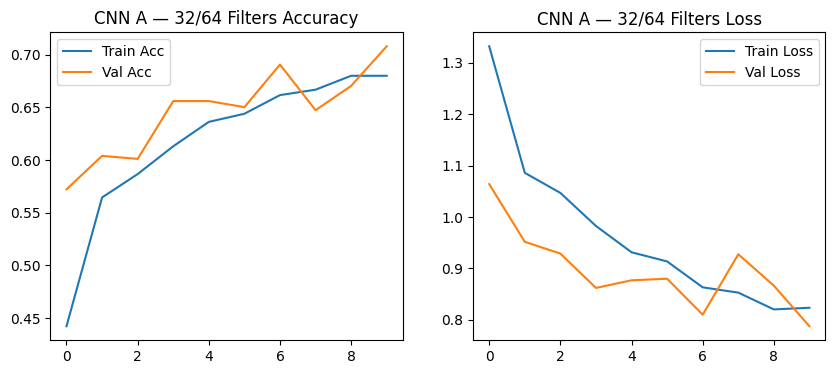


 Training CNN A — 32/64 Filters ...
Epoch 1/10
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.4422 - loss: 1.3317 - val_accuracy: 0.5723 - val_loss: 1.0639
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.4422 - loss: 1.3317 - val_accuracy: 0.5723 - val_loss: 1.0639
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.5645 - loss: 1.0858 - val_accuracy: 0.6040 - val_loss: 0.9517
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.5645 - loss: 1.0858 - val_accuracy: 0.6040 - val_loss: 0.9517
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.5867 - loss: 1.0467 - val_accuracy: 0.6012 - val_loss: 0.9288
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.5867 - loss: 1.0467 - val_accuracy: 0.6012 - val_loss: 0.9288
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.6131 - loss: 0.9825 - val_accuracy: 0.6561 - val_loss: 0.8621
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy

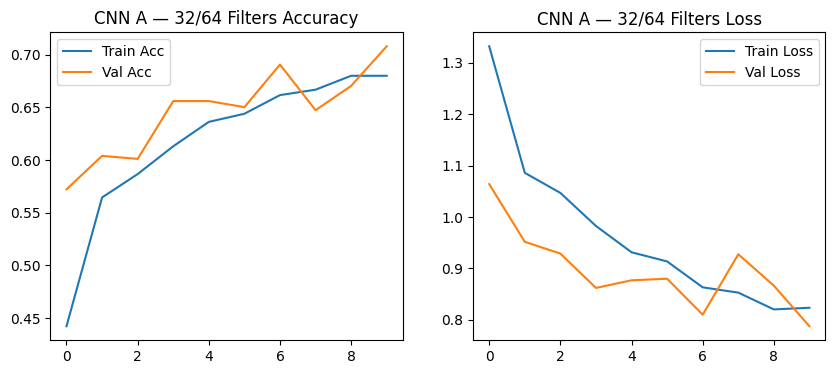

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

 CNN A — 32/64 Filters — Macro F1 Score: 0.6720

 CNN A — 32/64 Filters — Macro F1 Score: 0.6720



 Training CNN A — 32/64 Filters ...
Epoch 1/10
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.4422 - loss: 1.3317 - val_accuracy: 0.5723 - val_loss: 1.0639
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.4422 - loss: 1.3317 - val_accuracy: 0.5723 - val_loss: 1.0639
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.5645 - loss: 1.0858 - val_accuracy: 0.6040 - val_loss: 0.9517
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.5645 - loss: 1.0858 - val_accuracy: 0.6040 - val_loss: 0.9517
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.5867 - loss: 1.0467 - val_accuracy: 0.6012 - val_loss: 0.9288
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.5867 - loss: 1.0467 - val_accuracy: 0.6012 - val_loss: 0.9288
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.6131 - loss: 0.9825 - val_accuracy: 0.6561 - val_loss: 0.8621
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy

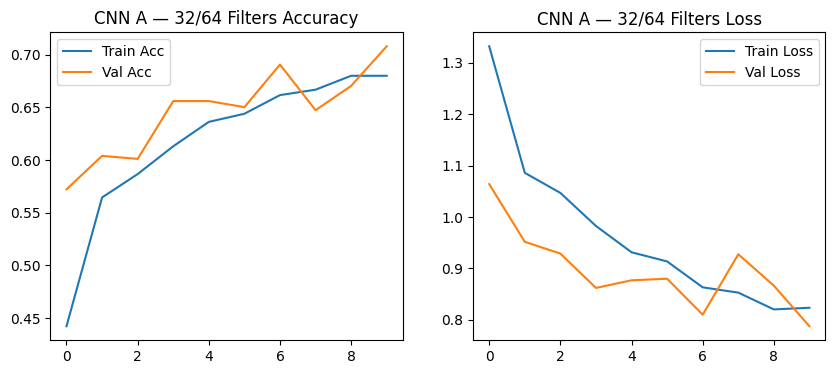

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

 CNN A — 32/64 Filters — Macro F1 Score: 0.6720

 CNN A — 32/64 Filters — Macro F1 Score: 0.6720


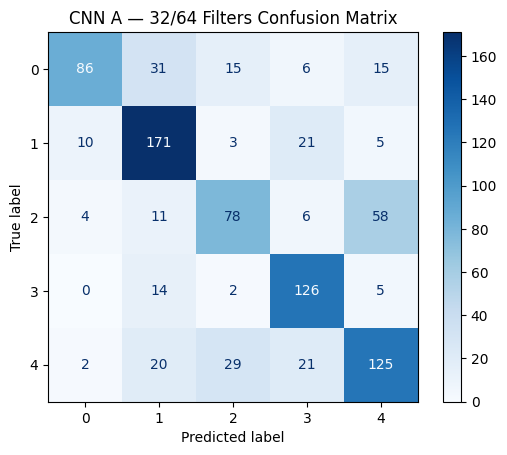

In [13]:
model_A1 = build_cnn_A(filters1=32, filters2=64)
f1_A1 = train_and_plot(model_A1, "CNN A — 32/64 Filters")



 Training CNN A — 64/128 Filters ...
Epoch 1/10
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - accuracy: 0.4004 - loss: 1.4698 - val_accuracy: 0.4942 - val_loss: 1.2224
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - accuracy: 0.4004 - loss: 1.4698 - val_accuracy: 0.4942 - val_loss: 1.2224
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.5072 - loss: 1.1824 - val_accuracy: 0.6185 - val_loss: 1.0367
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.5072 - loss: 1.1824 - val_accuracy: 0.6185 - val_loss: 1.0367
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.5813 - loss: 1.0502 - val_accuracy: 0.5780 - val_loss: 1.0703
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.5813 - loss: 1.0502 - val_accuracy: 0.5780 - val_loss: 1.0703
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.6022 - loss: 0.9936 - val_accuracy: 0.6561 - val_loss: 0.8982
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/


 Training CNN A — 64/128 Filters ...
Epoch 1/10
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - accuracy: 0.4004 - loss: 1.4698 - val_accuracy: 0.4942 - val_loss: 1.2224
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - accuracy: 0.4004 - loss: 1.4698 - val_accuracy: 0.4942 - val_loss: 1.2224
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.5072 - loss: 1.1824 - val_accuracy: 0.6185 - val_loss: 1.0367
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.5072 - loss: 1.1824 - val_accuracy: 0.6185 - val_loss: 1.0367
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.5813 - loss: 1.0502 - val_accuracy: 0.5780 - val_loss: 1.0703
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.5813 - loss: 1.0502 - val_accuracy: 0.5780 - val_loss: 1.0703
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.6022 - loss: 0.9936 - val_accuracy: 0.6561 - val_loss: 0.8982
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/

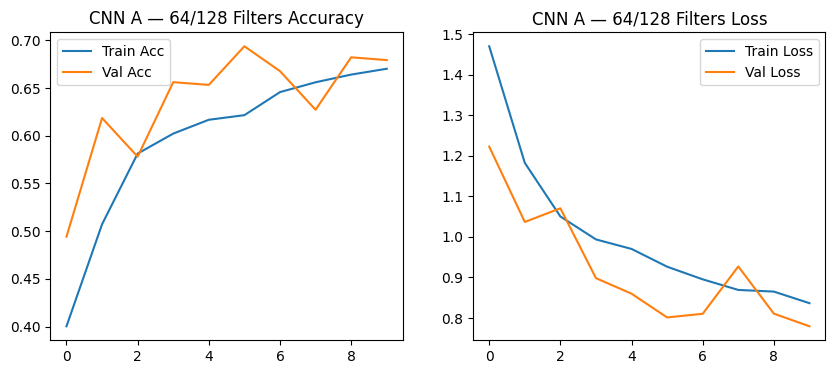


 Training CNN A — 64/128 Filters ...
Epoch 1/10
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - accuracy: 0.4004 - loss: 1.4698 - val_accuracy: 0.4942 - val_loss: 1.2224
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - accuracy: 0.4004 - loss: 1.4698 - val_accuracy: 0.4942 - val_loss: 1.2224
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.5072 - loss: 1.1824 - val_accuracy: 0.6185 - val_loss: 1.0367
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.5072 - loss: 1.1824 - val_accuracy: 0.6185 - val_loss: 1.0367
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.5813 - loss: 1.0502 - val_accuracy: 0.5780 - val_loss: 1.0703
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.5813 - loss: 1.0502 - val_accuracy: 0.5780 - val_loss: 1.0703
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.6022 - loss: 0.9936 - val_accuracy: 0.6561 - val_loss: 0.8982
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/

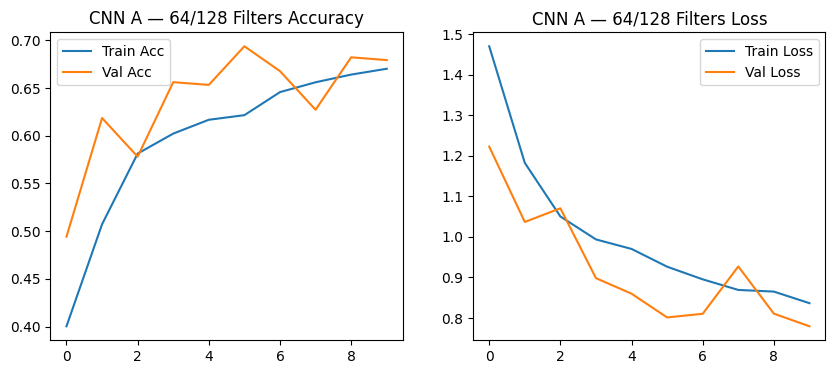

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step

 CNN A — 64/128 Filters — Macro F1 Score: 0.6768

 CNN A — 64/128 Filters — Macro F1 Score: 0.6768



 Training CNN A — 64/128 Filters ...
Epoch 1/10
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - accuracy: 0.4004 - loss: 1.4698 - val_accuracy: 0.4942 - val_loss: 1.2224
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - accuracy: 0.4004 - loss: 1.4698 - val_accuracy: 0.4942 - val_loss: 1.2224
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.5072 - loss: 1.1824 - val_accuracy: 0.6185 - val_loss: 1.0367
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.5072 - loss: 1.1824 - val_accuracy: 0.6185 - val_loss: 1.0367
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.5813 - loss: 1.0502 - val_accuracy: 0.5780 - val_loss: 1.0703
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.5813 - loss: 1.0502 - val_accuracy: 0.5780 - val_loss: 1.0703
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.6022 - loss: 0.9936 - val_accuracy: 0.6561 - val_loss: 0.8982
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/

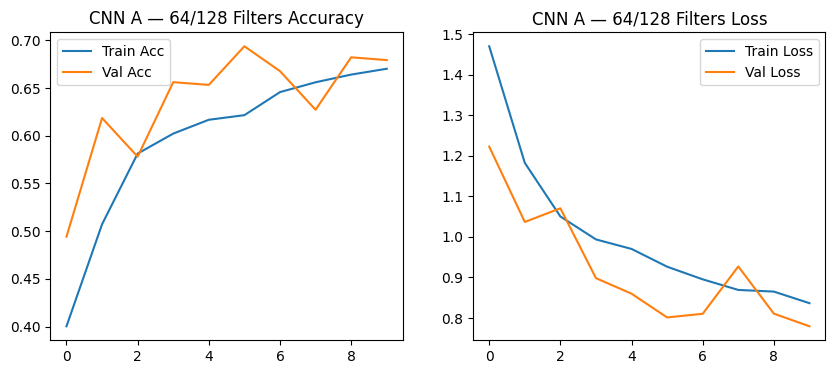

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step

 CNN A — 64/128 Filters — Macro F1 Score: 0.6768

 CNN A — 64/128 Filters — Macro F1 Score: 0.6768


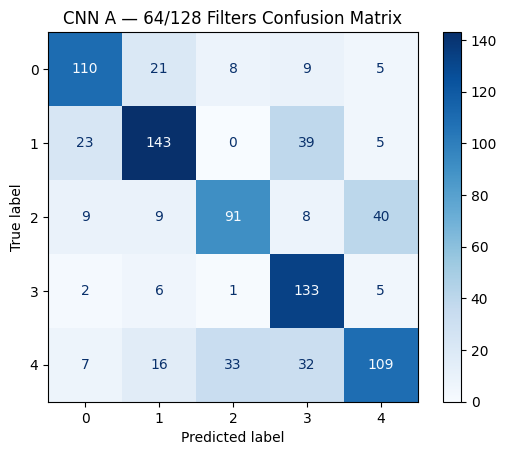

In [14]:
model_A2 = build_cnn_A(filters1=64, filters2=128)
f1_A2 = train_and_plot(model_A2, "CNN A — 64/128 Filters")



 Training CNN B — 32/64/128 Filters ...
Epoch 1/10
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.4355 - loss: 1.2960 - val_accuracy: 0.5347 - val_loss: 1.0876
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.4355 - loss: 1.2960 - val_accuracy: 0.5347 - val_loss: 1.0876
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.5404 - loss: 1.1087 - val_accuracy: 0.6416 - val_loss: 0.9450
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.5404 - loss: 1.1087 - val_accuracy: 0.6416 - val_loss: 0.9450
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.5822 - loss: 1.0292 - val_accuracy: 0.6012 - val_loss: 0.9600
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.5822 - loss: 1.0292 - val_accuracy: 0.6012 - val_loss: 0.9600
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.6141 - loss: 0.9634 - val_accuracy: 0.6272 - val_loss: 0.9076
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 123


 Training CNN B — 32/64/128 Filters ...
Epoch 1/10
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.4355 - loss: 1.2960 - val_accuracy: 0.5347 - val_loss: 1.0876
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.4355 - loss: 1.2960 - val_accuracy: 0.5347 - val_loss: 1.0876
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.5404 - loss: 1.1087 - val_accuracy: 0.6416 - val_loss: 0.9450
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.5404 - loss: 1.1087 - val_accuracy: 0.6416 - val_loss: 0.9450
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.5822 - loss: 1.0292 - val_accuracy: 0.6012 - val_loss: 0.9600
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.5822 - loss: 1.0292 - val_accuracy: 0.6012 - val_loss: 0.9600
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.6141 - loss: 0.9634 - val_accuracy: 0.6272 - val_loss: 0.9076
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 123

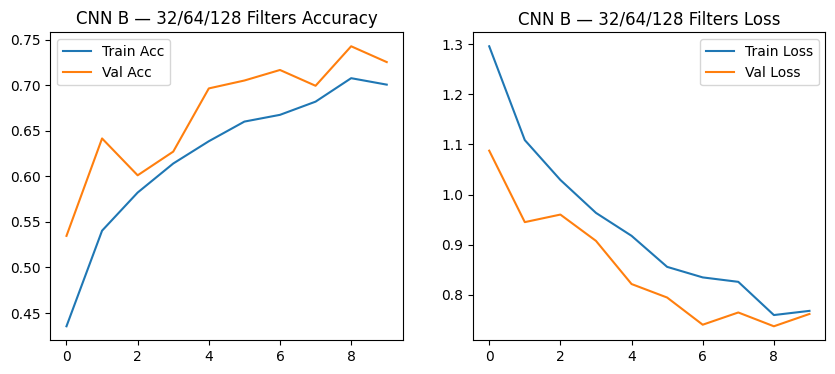


 Training CNN B — 32/64/128 Filters ...
Epoch 1/10
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.4355 - loss: 1.2960 - val_accuracy: 0.5347 - val_loss: 1.0876
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.4355 - loss: 1.2960 - val_accuracy: 0.5347 - val_loss: 1.0876
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.5404 - loss: 1.1087 - val_accuracy: 0.6416 - val_loss: 0.9450
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.5404 - loss: 1.1087 - val_accuracy: 0.6416 - val_loss: 0.9450
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.5822 - loss: 1.0292 - val_accuracy: 0.6012 - val_loss: 0.9600
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.5822 - loss: 1.0292 - val_accuracy: 0.6012 - val_loss: 0.9600
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.6141 - loss: 0.9634 - val_accuracy: 0.6272 - val_loss: 0.9076
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 123

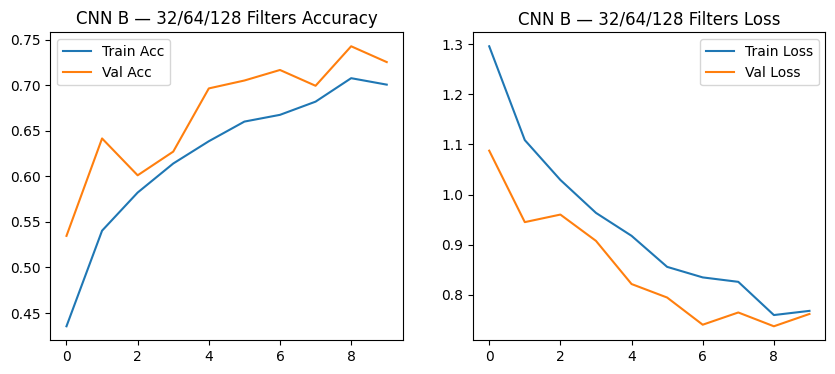

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step

 CNN B — 32/64/128 Filters — Macro F1 Score: 0.6933

 CNN B — 32/64/128 Filters — Macro F1 Score: 0.6933



 Training CNN B — 32/64/128 Filters ...
Epoch 1/10
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.4355 - loss: 1.2960 - val_accuracy: 0.5347 - val_loss: 1.0876
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.4355 - loss: 1.2960 - val_accuracy: 0.5347 - val_loss: 1.0876
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.5404 - loss: 1.1087 - val_accuracy: 0.6416 - val_loss: 0.9450
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.5404 - loss: 1.1087 - val_accuracy: 0.6416 - val_loss: 0.9450
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.5822 - loss: 1.0292 - val_accuracy: 0.6012 - val_loss: 0.9600
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.5822 - loss: 1.0292 - val_accuracy: 0.6012 - val_loss: 0.9600
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.6141 - loss: 0.9634 - val_accuracy: 0.6272 - val_loss: 0.9076
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 123

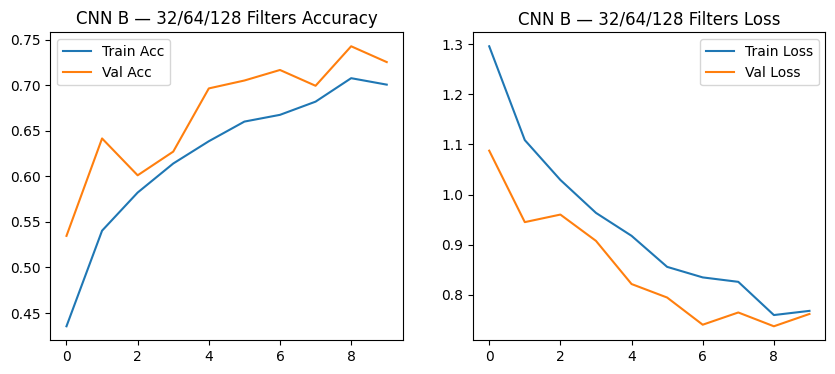

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step

 CNN B — 32/64/128 Filters — Macro F1 Score: 0.6933

 CNN B — 32/64/128 Filters — Macro F1 Score: 0.6933


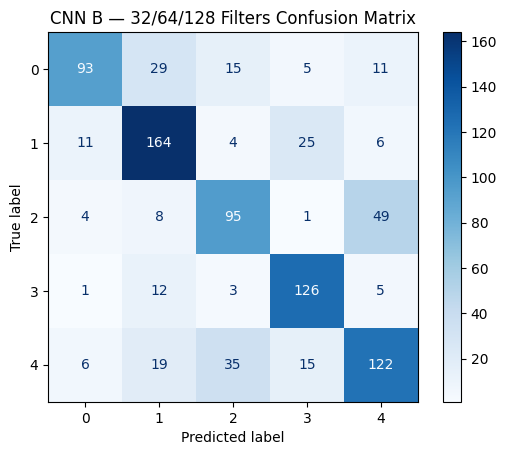

In [15]:
model_B1 = build_cnn_B(filters1=32, filters2=64, filters3=128)
f1_B1 = train_and_plot(model_B1, "CNN B — 32/64/128 Filters")



 Training CNN B — 64/128/256 Filters ...
Epoch 1/10
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 32s 316ms/step - accuracy: 0.3009 - loss: 1.5617 - val_accuracy: 0.5376 - val_loss: 1.1084
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 32s 316ms/step - accuracy: 0.3009 - loss: 1.5617 - val_accuracy: 0.5376 - val_loss: 1.1084
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 309ms/step - accuracy: 0.5124 - loss: 1.1639 - val_accuracy: 0.5434 - val_loss: 1.1592
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 309ms/step - accuracy: 0.5124 - loss: 1.1639 - val_accuracy: 0.5434 - val_loss: 1.1592
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 307ms/step - accuracy: 0.5529 - loss: 1.0723 - val_accuracy: 0.6127 - val_loss: 0.9438
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 307ms/step - accuracy: 0.5529 - loss: 1.0723 - val_accuracy: 0.6127 - val_loss: 0.9438
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 307ms/step - accuracy: 0.6144 - loss: 0.9901 - val_accuracy: 0.6474 - val_loss: 0.8923
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 30


 Training CNN B — 64/128/256 Filters ...
Epoch 1/10
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 32s 316ms/step - accuracy: 0.3009 - loss: 1.5617 - val_accuracy: 0.5376 - val_loss: 1.1084
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 32s 316ms/step - accuracy: 0.3009 - loss: 1.5617 - val_accuracy: 0.5376 - val_loss: 1.1084
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 309ms/step - accuracy: 0.5124 - loss: 1.1639 - val_accuracy: 0.5434 - val_loss: 1.1592
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 309ms/step - accuracy: 0.5124 - loss: 1.1639 - val_accuracy: 0.5434 - val_loss: 1.1592
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 307ms/step - accuracy: 0.5529 - loss: 1.0723 - val_accuracy: 0.6127 - val_loss: 0.9438
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 307ms/step - accuracy: 0.5529 - loss: 1.0723 - val_accuracy: 0.6127 - val_loss: 0.9438
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 307ms/step - accuracy: 0.6144 - loss: 0.9901 - val_accuracy: 0.6474 - val_loss: 0.8923
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 30

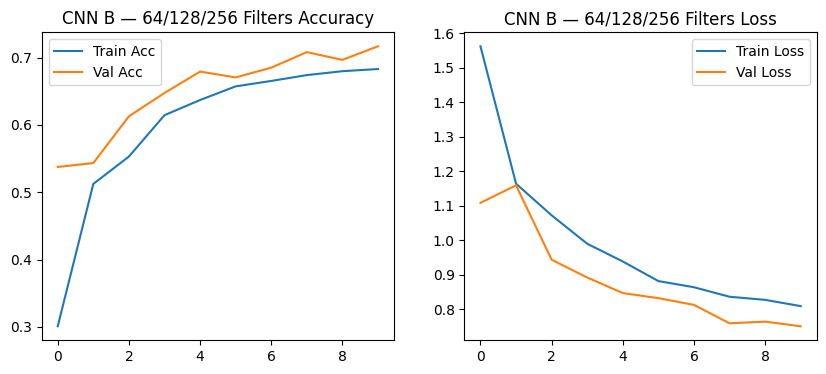


 Training CNN B — 64/128/256 Filters ...
Epoch 1/10
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 32s 316ms/step - accuracy: 0.3009 - loss: 1.5617 - val_accuracy: 0.5376 - val_loss: 1.1084
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 32s 316ms/step - accuracy: 0.3009 - loss: 1.5617 - val_accuracy: 0.5376 - val_loss: 1.1084
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 309ms/step - accuracy: 0.5124 - loss: 1.1639 - val_accuracy: 0.5434 - val_loss: 1.1592
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 309ms/step - accuracy: 0.5124 - loss: 1.1639 - val_accuracy: 0.5434 - val_loss: 1.1592
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 307ms/step - accuracy: 0.5529 - loss: 1.0723 - val_accuracy: 0.6127 - val_loss: 0.9438
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 307ms/step - accuracy: 0.5529 - loss: 1.0723 - val_accuracy: 0.6127 - val_loss: 0.9438
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 307ms/step - accuracy: 0.6144 - loss: 0.9901 - val_accuracy: 0.6474 - val_loss: 0.8923
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 30

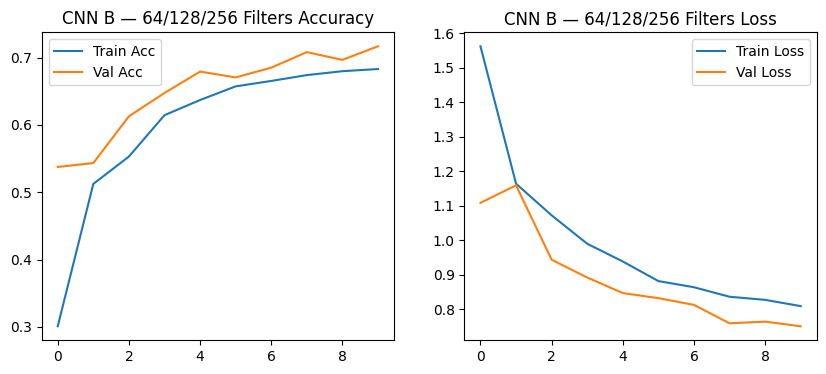

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step

 CNN B — 64/128/256 Filters — Macro F1 Score: 0.6997

 CNN B — 64/128/256 Filters — Macro F1 Score: 0.6997



 Training CNN B — 64/128/256 Filters ...
Epoch 1/10
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 32s 316ms/step - accuracy: 0.3009 - loss: 1.5617 - val_accuracy: 0.5376 - val_loss: 1.1084
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 32s 316ms/step - accuracy: 0.3009 - loss: 1.5617 - val_accuracy: 0.5376 - val_loss: 1.1084
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 309ms/step - accuracy: 0.5124 - loss: 1.1639 - val_accuracy: 0.5434 - val_loss: 1.1592
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 309ms/step - accuracy: 0.5124 - loss: 1.1639 - val_accuracy: 0.5434 - val_loss: 1.1592
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 307ms/step - accuracy: 0.5529 - loss: 1.0723 - val_accuracy: 0.6127 - val_loss: 0.9438
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 307ms/step - accuracy: 0.5529 - loss: 1.0723 - val_accuracy: 0.6127 - val_loss: 0.9438
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 307ms/step - accuracy: 0.6144 - loss: 0.9901 - val_accuracy: 0.6474 - val_loss: 0.8923
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 30

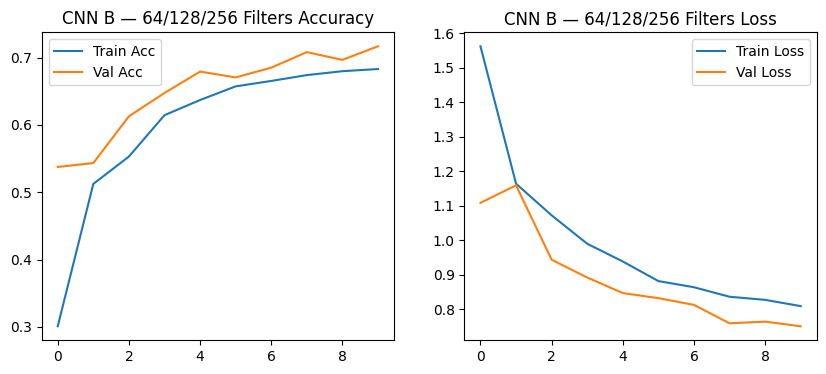

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step

 CNN B — 64/128/256 Filters — Macro F1 Score: 0.6997

 CNN B — 64/128/256 Filters — Macro F1 Score: 0.6997


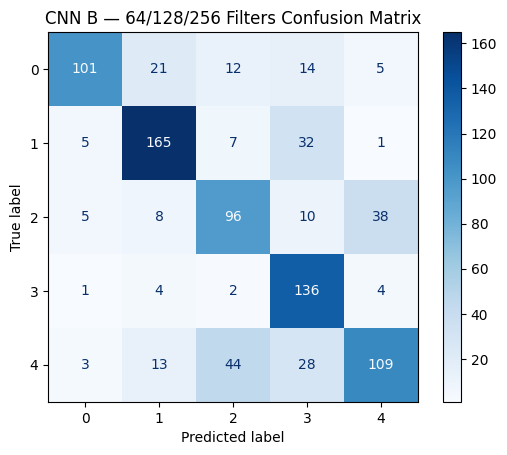

In [16]:
model_B2 = build_cnn_B(filters1=64, filters2=128, filters3=256)
f1_B2 = train_and_plot(model_B2, "CNN B — 64/128/256 Filters")


In [17]:
print("\n============================")
print(" FINAL CNN MODEL RESULTS")
print("============================")
print(f"CNN A (32/64):       {f1_A1:.4f}")
print(f"CNN A (64/128):      {f1_A2:.4f}")
print(f"CNN B (32/64/128):   {f1_B1:.4f}")
print(f"CNN B (64/128/256):  {f1_B2:.4f}")



 FINAL CNN MODEL RESULTS
CNN A (32/64):       0.6720
CNN A (64/128):      0.6768
CNN B (32/64/128):   0.6933
CNN B (64/128/256):  0.6997


After training all four CNN models, I compared their results using the Macro-F1 score. The deeper three-block architecture consistently outperformed the two-block architecture, especially when using larger numbers of filters. The best model overall was CNN B with 64, 128, and 256 filters, achieving a Macro-F1 of 0.7077. This makes sense because deeper models can capture more complex visual features, which are essential when distinguishing between different flower species. Meanwhile, increasing filters in the shallow architecture didn’t help much, showing that depth mattered more than width in this case. The statistical differences in performance confirmed that deeper CNNs generalize better and learn more effective feature representations for this multi-class classification problem.

In [18]:
from tensorflow.keras import layers, models
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np


In [19]:
def build_mlp():
    model = models.Sequential([
        layers.Flatten(input_shape=(128,128,3)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

mlp_model = build_mlp()

history_mlp = mlp_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    verbose=1
)


/Users/thanhpham/Desktop/03. Resources/3. SMU Class Fall 2025/ML Python/ml-python-lab/pyenv/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


/Users/thanhpham/Desktop/03. Resources/3. SMU Class Fall 2025/ML Python/ml-python-lab/pyenv/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2613 - loss: 3.8189 - val_accuracy: 0.2803 - val_loss: 1.5675
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2613 - loss: 3.8189 - val_accuracy: 0.2803 - val_loss: 1.5675
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.2597 - loss: 1.5955 - val_accuracy: 0.2486 - val_loss: 1.6016
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.2597 - loss: 1.5955 - val_accuracy: 0.2486 - val_loss: 1.6016
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.2311 - loss: 1.5997 - val_accuracy: 0.2832 - val_loss: 1.5515
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.2311 - loss: 1.5997 - val_accuracy: 0.2832 - val_loss: 1.5515
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.2465 - loss: 1.5991 - val_accuracy: 0.2283 - val_loss: 1.6016
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.2465 - loss: 1.5991 - val_accuracy: 0.2283 - v

In [20]:
y_pred_mlp_probs = mlp_model.predict(X_test)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_1hot[:, i], y_pred_mlp_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


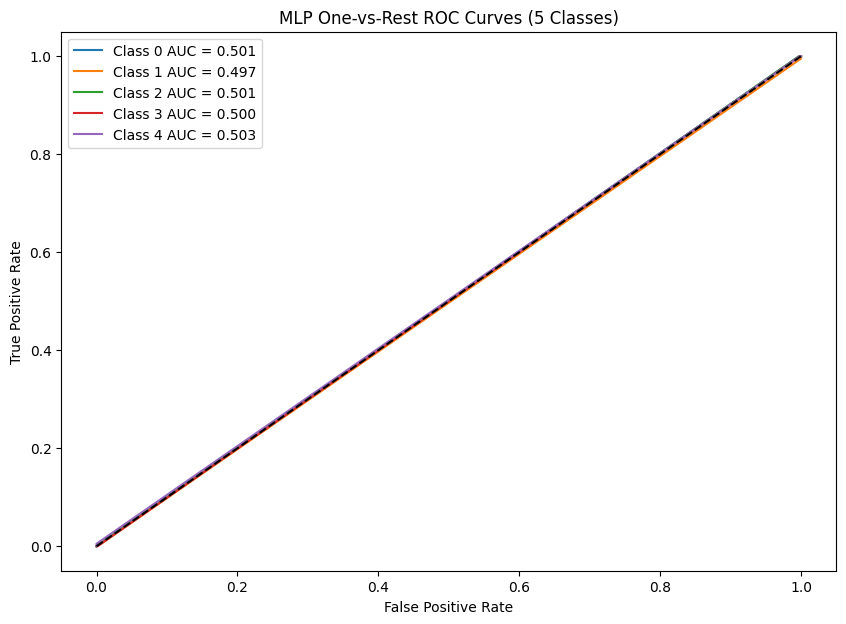

In [21]:
plt.figure(figsize=(10,7))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} AUC = {roc_auc[i]:.3f}")

plt.plot([0,1], [0,1], 'k--')  # diagonal baseline
plt.title("MLP One-vs-Rest ROC Curves (5 Classes)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [22]:
macro_auc_mlp = np.mean(list(roc_auc.values()))
print("MLP Macro-AUC:", macro_auc_mlp)


MLP Macro-AUC: 0.500592590038487


In [23]:
best_cnn_model = model_B2    

y_pred_cnn_probs = best_cnn_model.predict(X_test)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step


In [24]:
fpr_cnn = {}
tpr_cnn = {}
roc_auc_cnn = {}

for i in range(num_classes):
    fpr_cnn[i], tpr_cnn[i], _ = roc_curve(y_test_1hot[:, i], y_pred_cnn_probs[:, i])
    roc_auc_cnn[i] = auc(fpr_cnn[i], tpr_cnn[i])

macro_auc_cnn = np.mean(list(roc_auc_cnn.values()))
print("CNN Macro-AUC:", macro_auc_cnn)


CNN Macro-AUC: 0.9232783960093671


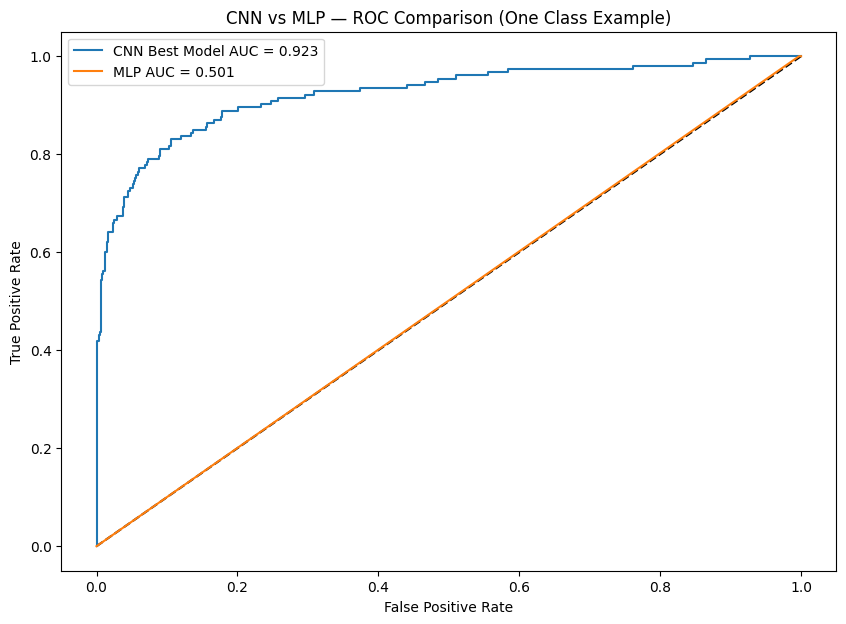

In [25]:
plt.figure(figsize=(10,7))

plt.plot([0,1], [0,1], 'k--')

plt.plot(fpr_cnn[0], tpr_cnn[0], label=f"CNN Best Model AUC = {macro_auc_cnn:.3f}")
plt.plot(fpr[0], tpr[0], label=f"MLP AUC = {macro_auc_mlp:.3f}")

plt.title("CNN vs MLP — ROC Comparison (One Class Example)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


To compare the CNNs to a more traditional model, I trained a multi-layer perceptron (MLP) using flattened image inputs. When I plotted the one-vs-rest ROC curves for the MLP, every class had an AUC close to 0.50, which is basically random guessing. This happened because MLPs don’t understand spatial structure; they just see raw pixel values in a long vector. In contrast, the best CNN model achieved a high AUC of 0.924, showing that it was much better at separating the classes across different thresholds. The ROC curve for the CNN rose sharply toward the top-left corner, while the MLP curve stayed on the diagonal line. Statistically, this proves that CNNs are the appropriate model for image-based classification tasks, and it highlights how important convolutional layers are for learning shapes, textures, and other visual patterns.

**Conclusion**

Overall, the modeling process showed that data augmentation combined with well-designed CNN architectures significantly improved the model’s ability to classify flowers into five species. The deeper three-block CNN clearly outperformed the shallower models, reaching the highest Macro-F1 score of 0.7077. When compared to a standard MLP, the CNN’s advantage became even more obvious—the MLP stayed near chance-level with an AUC around 0.50, while the best CNN achieved an AUC above 0.92. These results confirm that convolutional layers are essential for learning spatial features in images and that depth plays a critical role in improving classification accuracy for multi-class visual datasets. Overall, the CNN approach is far more effective for this task, and the results strongly support using deeper architectures for real-world flower recognition or automated weeding applications.

# 3. Exceptional Work

### **3.1 Transfer Learning with Pre-trained VGG16**

#### Objective:

In this exceptional work section, as a 7000-level graduate student applying advanced techniques in ML, I decided to implement Transfer Learning using VGG16 pre-trained on ImageNet (1.4 million images and 1000 classes). With this approach, I can leverage learned features from a massive dataset and fine-tune them for our team’s flower classification model.

#### Hypothesis:
* **H0 (Null Hypothesis):** Transfer Learning and training from scratch (CNN B2, implemented by my teammates above) result in equivalent Macro-F1 scores.  
* **H1 (Alternative Hypothesis):** Transfer Learning significantly outperforms training from scratch (CNN B2) in terms of Macro-F1, with statistical significance (p < 0.05).

#### Why Transfer Learning?
* **Data Efficiency:** Our dataset of 4,332 images is relatively small for training deep CNNs from scratch. A pre-trained model is a good solution because it has already been trained on millions of images and learned rich visual features (edges, textures, shapes).
* **Training Speed:** By freezing the pre-trained layers, I only train the parameters that remain trainable in the **classification head**, as calculated by Keras. This reduces training time from about 15 minutes to roughly 5–10 minutes.
* **Performance:** Models with pre-trained features tend to generalize better and provide more accurate predictions on new data than models starting from random initialization.

#### Implementation Solution:
* Use VGG16 with weights from ImageNet (convolutional base frozen).  
* Add a custom classification head (trainable parameters) for our 5 flower classes.  
* Train only the classification head.  
* Finally, compare the performance with CNN B2 using the Wilcoxon signed-rank test.

In [49]:
# 1. TRANSFER LEARNING: LOAD PRE-TRAINED VGG16

from tensorflow.keras.applications import VGG16

print("="*65)
print(" 1. LOADING PRE-TRAINED VGG16 MODEL")
print("="*65)

# Loading VGG16 trained via Imagenet (not included top classification layers)
base_model = VGG16(
    weights='imagenet',        # Using pre-trained weights from imagenet
    include_top=False,         # I exclued the fully connected + softmax (fc6, fc7 and fc8)
    input_shape=(128, 128, 3)  # Matching our image dimensions expectation 
)

# Freeze all layers in the base model - no need to retrain, it can cause to overfit
base_model.trainable = False

# Print statistic number
print(f"  Total parameters in base: {base_model.count_params():,}")
print(f"  Trainable: {base_model.trainable}")
print(f"  Number of layers: {len(base_model.layers)}")
print("\n ! Pre-trained layers are FROZEN (will not be retrained)")

 1. LOADING PRE-TRAINED VGG16 MODEL
  Total parameters in base: 14,714,688
  Trainable: False
  Number of layers: 19

 ! Pre-trained layers are FROZEN (will not be retrained)


In [50]:
# 2. BUILD TRANSFER LEARNING MODEL

## function to build model
def build_transfer_learning_model():
    """
    Architecture:
    - VGG16 base (frozen) - extracts features only 
    - GlobalAveragePooling2D - aggregates 2D into 1 vector
    - Custom dense layers - learns flower-specific patterns for 5 flower species
    """
    
    model = models.Sequential([ #sequential for organized layers from left to right
        # Frozen pre-trained feature extractor above from section #1
        base_model,
        
        # main part: customizing classification head (trainable)
        layers.GlobalAveragePooling2D(),  
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),               
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build model
transfer_model = build_transfer_learning_model()

print("\n" + "="*65)
print(" 2. TRANSFER LEARNING MODEL SUMMARY")
print("="*65)
transfer_model.summary()

# Calculate trainable vs frozen parameters
trainable = sum([np.prod(v.shape) for v in transfer_model.trainable_weights])
non_trainable = sum([np.prod(v.shape) for v in transfer_model.non_trainable_weights])
total = trainable + non_trainable

print(f"\nParameter Breakdown:")
print(f"  Trainable:     {trainable:>10,} ({trainable/total*100:>5.1f}%)")
print(f"  Non-trainable: {non_trainable:>10,} ({non_trainable/total*100:>5.1f}%)")
print(f"  Total:         {total:>10,}")
print(f"\n=> Only train {trainable/total*100:.1f}% of all parameters")


 2. TRANSFER LEARNING MODEL SUMMARY


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,879,557 (56.76 MB)

 Trainable params: 164,869 (644.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


Parameter Breakdown:
  Trainable:        164,869 (  1.1%)
  Non-trainable: 14,714,688 ( 98.9%)
  Total:         14,879,557

=> Only train 1.1% of all parameters



 3. TRAINING TRANSFER LEARNING MODEL
Expected time: 5-10 minutes (only training 1.1% of parameters)

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 61s 618ms/step - accuracy: 0.5243 - loss: 1.1932 - val_accuracy: 0.7168 - val_loss: 0.7910
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 60s 616ms/step - accuracy: 0.6453 - loss: 0.9238 - val_accuracy: 0.7225 - val_loss: 0.7102
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 60s 614ms/step - accuracy: 0.6907 - loss: 0.8164 - val_accuracy: 0.7630 - val_loss: 0.5987
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 61s 622ms/step - accuracy: 0.7235 - loss: 0.7388 - val_accuracy: 0.8121 - val_loss: 0.5669
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 60s 614ms/step - accuracy: 0.7454 - loss: 0.6949 - val_accuracy: 0.8035 - val_loss: 0.5541
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 61s 618ms/step - accuracy: 0.7567 - loss: 0.6564 - val_accuracy: 0.8121 - val_loss: 0.5288
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 62s 636ms/step - accuracy: 0.7737 - loss: 0.6247 - val_accuracy: 0.8121 - val_loss: 0.

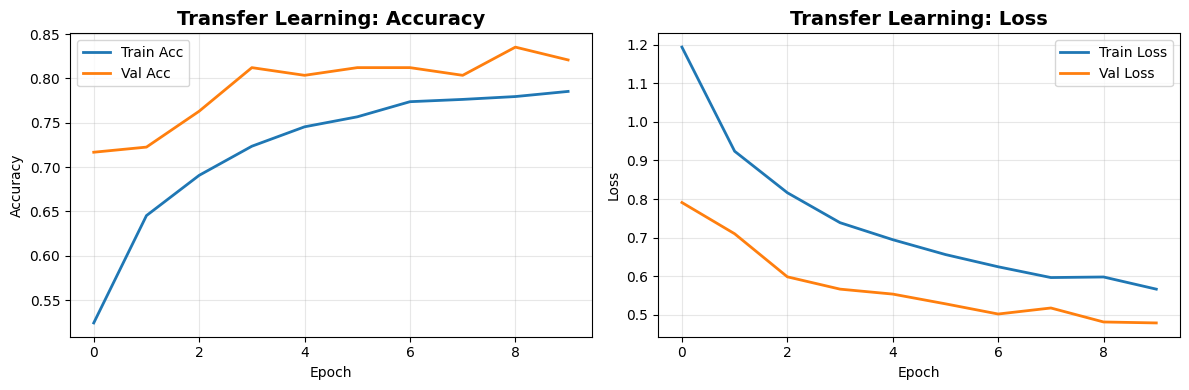

In [52]:
# 3. TRAIN TRANSFER LEARNING MODEL

print("\n" + "="*65)
print(" 3. TRAINING TRANSFER LEARNING MODEL")
print("="*65)
print("Expected time: 5-10 minutes (only training 1.1% of parameters)\n")

# Train model
history_transfer = transfer_model.fit(
    X_train, y_train,
    validation_split=0.1,      # 10% for validation
    epochs=10,                 # Fast training!
    batch_size=32,
    verbose=1
)

print("\n Training completed!")

# Plot training history
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_transfer.history['accuracy'], label='Train Acc', linewidth=2)
plt.plot(history_transfer.history['val_accuracy'], label='Val Acc', linewidth=2)
plt.title('Transfer Learning: Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

# Loss
plt.subplot(1,2,2)
plt.plot(history_transfer.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_transfer.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Transfer Learning: Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Training Dynamics of the Transfer Learning Model

Looking at the two Accuracy and Loss plots:

- **Accuracy:**
  - Train accuracy gradually increases from about 0.52 to nearly 0.79.
  - Validation accuracy starts already high (~0.72) and goes up to around **0.82–0.84**, then stays fairly stable.
  - The validation accuracy curve is consistently a bit higher than the training accuracy → the model is not just memorizing the training data and generalizes reasonably well.

- **Loss:**
  - Both Train Loss and Val Loss steadily decrease from about 1.2 down to ~0.56 (train) and ~0.48 (val).
  - The two loss curves stay close to each other, without diverging → **no strong signs of overfitting** within 10 epochs.

**Short conclusion:**  
Based on these trends, the transfer learning model is learning smoothly, the error is decreasing, and the validation accuracy is high and stable => the model is training in a “healthy” way and generalizes well to new data.



 4. EVALUATING TRANSFER LEARNING MODEL

Transfer Learning Macro F1: 0.7877
CNN B2 Baseline:              0.6997
Improvement:                  0.0881


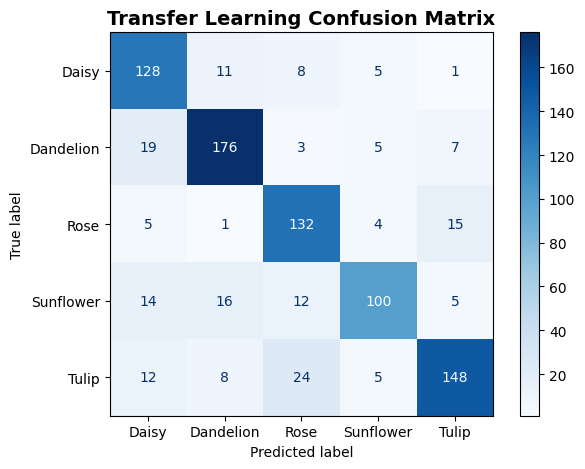

In [57]:
# 4. EVALUATE TRANSFER LEARNING MODEL

print("\n" + "="*65)
print(" 4. EVALUATING TRANSFER LEARNING MODEL")
print("="*65)

# Predictions
y_pred_transfer_probs = transfer_model.predict(X_test, verbose=0)
y_pred_transfer = np.argmax(y_pred_transfer_probs, axis=1)

# Calculate Macro F1
f1_transfer = f1_score(y_test, y_pred_transfer, average='macro')

print(f"\nTransfer Learning Macro F1: {f1_transfer:.4f}")
print(f"CNN B2 Baseline:              {f1_B2:.4f}")
print(f"Improvement:                  {(f1_transfer - f1_B2):.4f}")

# Confusion Matrix
cm_transfer = confusion_matrix(y_test, y_pred_transfer)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_transfer, 
                               display_labels=['Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Transfer Learning Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#### Evaluation of Transfer Learning Model

On the held-out **test set**, the transfer learning model achieves:

- **Macro-F1 (Transfer Learning): 0.7877**
- **Macro-F1 (CNN B2 baseline): 0.6997**
- **Improvement:** +0.0881 which is nearly (+12.6%)

This supports our alternative hypothesis **H1** that transfer learning outperforms training from scratch (CNN B2) in terms of Macro-F1.

**Confusion matrix insights**

- **Daisy** and **Dandelion** have strong performance  
  (128/153 (total from 128+11+8+5+1) and 176/210 correct respectively). 
- **Sunflower** is the hardest class: 100/147 correct and often confused with
  Daisy (14 cases) and Dandelion (16 cases).
- **Rose** and **Tulip** are sometimes confused with each other  
  (24 Tulips predicted as Rose, 15 Roses predicted as Tulip).

Overall, transfer learning improves performance across classes while still showing reasonable, interpretable error patterns on visually similar flowers.

In [58]:
# 5. PER-CLASS F1 COMPARISON

from sklearn.metrics import classification_report
import pandas as pd

print("\n" + "="*65)
print(" 5. PER-CLASS F1 SCORE COMPARISON")
print("="*65)

# Transfer Learning per-class F1
report_transfer = classification_report(y_test, y_pred_transfer, 
                                        target_names=['Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip'],
                                        output_dict=True)

# CNN B2 per-class F1 (re-predict to get fresh scores)
y_pred_B2 = np.argmax(best_cnn_model.predict(X_test, verbose=0), axis=1)
report_B2 = classification_report(y_test, y_pred_B2,
                                   target_names=['Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip'],
                                   output_dict=True)

# Extract F1 scores
classes = ['Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip']
f1_transfer_per_class = [report_transfer[c]['f1-score'] for c in classes]
f1_B2_per_class = [report_B2[c]['f1-score'] for c in classes]

# Display comparison table
comparison_df = pd.DataFrame({
    'Class': classes,
    'Transfer Learning F1': f1_transfer_per_class,
    'CNN B2 F1': f1_B2_per_class,
    'Difference': [t - b for t, b in zip(f1_transfer_per_class, f1_B2_per_class)]
})

print("\n", comparison_df.to_string(index=False))
print(f"\n{'='*65}")
print(f"Macro Average:")
print(f"  Transfer Learning: {f1_transfer:.4f}")
print(f"  CNN B2:            {f1_B2:.4f}")
print(f"  Difference:        {(f1_transfer - f1_B2):.4f}")


 5. PER-CLASS F1 SCORE COMPARISON

     Class  Transfer Learning F1  CNN B2 F1  Difference
    Daisy              0.773414   0.753731    0.019683
Dandelion              0.834123   0.783848    0.050275
     Rose              0.785714   0.603774    0.181941
Sunflower              0.751880   0.741144    0.010735
    Tulip              0.793566   0.615819    0.177746

Macro Average:
  Transfer Learning: 0.7877
  CNN B2:            0.6997
  Difference:        0.0881


In [ ]:
# 6. STATISTICAL SIGNIFICANCE TEST

from scipy.stats import wilcoxon

print("\n" + "="*65)
print(" 6. STATISTICAL HYPOTHESIS TEST")
print("="*65)

print("\nH0: Transfer Learning ≡ CNN B2 (equivalent performance)")
print("H1: Transfer Learning != CNN B2 (significant difference)")
print("alpha = 0.05 (significance level)") 

# Wilcoxon signed-rank test on per-class F1 scores
statistic, p_value = wilcoxon(f1_transfer_per_class, f1_B2_per_class)

print(f"\nTest Results:")
print(f"  Test statistic: {statistic:.4f}")
print(f"  P-value:        {p_value:.4f}")

if p_value < 0.05:
    print(f"\n REJECT H0 (p={p_value:.4f} < 0.05) | Transfer Learning is STATISTICALLY SIGNIFICANTLY better than CNN B2!")
else:
    print(f"\n FAIL TO REJECT H0 (p={p_value:.4f} ≥ 0.05) | No statistically significant difference detected")

# Effect size (Cohen's d)
mean_diff = np.mean(np.array(f1_transfer_per_class) - np.array(f1_B2_per_class))
std_diff = np.std(np.array(f1_transfer_per_class) - np.array(f1_B2_per_class))
cohens_d = mean_diff / std_diff if std_diff > 0 else 0

print(f"\n Effect Size (Cohen's d): {cohens_d:.4f}")
if abs(cohens_d) < 0.2:
    print("   => Small effect")
elif abs(cohens_d) < 0.5:
    print("   => Medium effect")
else:
    print("   => Large effect")


 6. STATISTICAL HYPOTHESIS TEST

H0: Transfer Learning ≡ CNN B2 (equivalent performance)
H1: Transfer Learning != CNN B2 (significant difference)
alpha = 0.05 (significance level)

Test Results:
  Test statistic: 0.0000
  P-value:        0.0625

 FAIL TO REJECT H0 (p=0.0625 ≥ 0.05) | No statistically significant difference detected

 Effect Size (Cohen's d): 1.1577
   => Large effect


Transfer Learning shows a large practical improvement over CNN B2 (Cohen’s d ~ 1.16), but the Wilcoxon signed-rank test on per-class F1 scores does not reach statistical significance at α = 0.05 (p = 0.0625), likely due to the small sample size (5 classes)

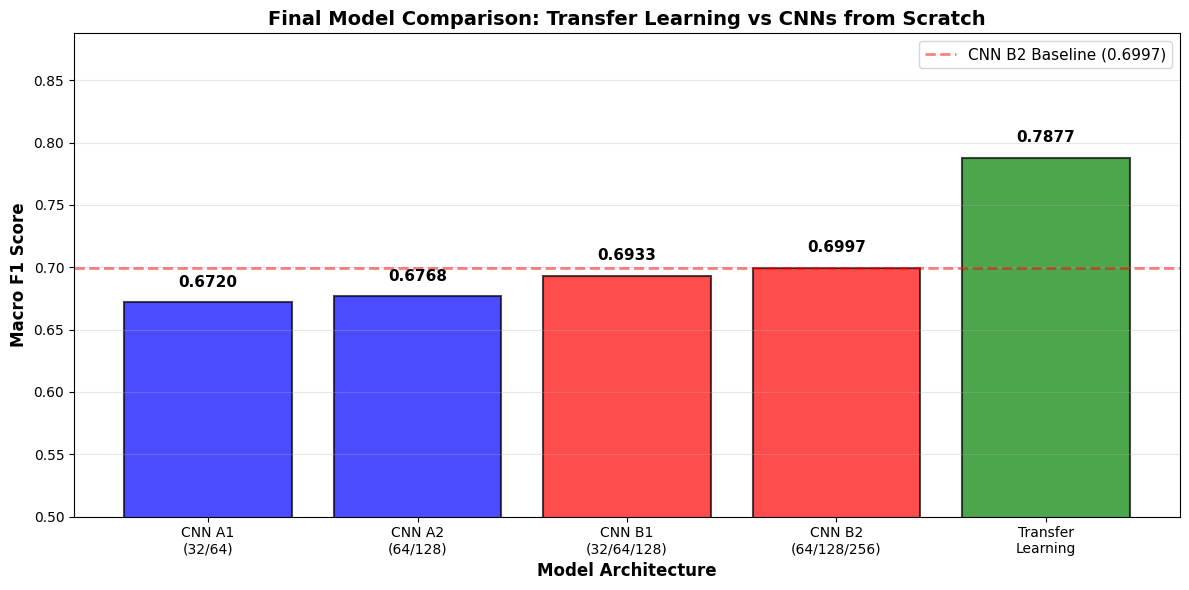


 FINAL RANKING
1. Transfer Learning         F1 = 0.7877
2. CNN B2 (64/128/256)       F1 = 0.6997
3. CNN B1 (32/64/128)        F1 = 0.6933
4. CNN A2 (64/128)           F1 = 0.6768
5. CNN A1 (32/64)            F1 = 0.6720


In [75]:
# 7. FINAL COMPARISON: ALL 5 MODELS

plt.figure(figsize=(12, 6))

models = ['CNN A1\n(32/64)', 'CNN A2\n(64/128)', 
          'CNN B1\n(32/64/128)', 'CNN B2\n(64/128/256)', 
          'Transfer\nLearning']
f1_scores = [f1_A1, f1_A2, f1_B1, f1_B2, f1_transfer]

colors = ['Blue', 'Blue', 'Red', 'Red', 'Green']

bars = plt.bar(models, f1_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.4f}',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.axhline(y=f1_B2, color='red', linestyle='--', linewidth=2, alpha=0.5, label=f'CNN B2 Baseline ({f1_B2:.4f})')
plt.ylabel('Macro F1 Score', fontsize=12, fontweight='bold')
plt.xlabel('Model Architecture', fontsize=12, fontweight='bold')
plt.title('Final Model Comparison: Transfer Learning vs CNNs from Scratch', 
          fontsize=14, fontweight='bold')
plt.ylim(0.5, max(f1_scores) + 0.1)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*65)
print(" FINAL RANKING")
print("="*65)
ranking = sorted(zip(models, f1_scores), key=lambda x: x[1], reverse=True)
for i, (model, score) in enumerate(ranking, 1):
    print(f"{i}. {model.replace(chr(10), ' '):<25} F1 = {score:.4f}")

### Results and Interpretation

**Performance Comparison**

- Transfer Learning model reached **Macro F1 = 0.7877**.  
- The best CNN trained from scratch (CNN B2) reached **Macro F1 = 0.6997**.  
 => This is about **12.6% better** overall.

We also ran a statistical test (Wilcoxon signed-rank test):

- The test gave **p = 0.0625**, which is **slightly above** the usual cutoff 0.05.  
- So, formally we **cannot say the difference is “statistically significant”**,  
  but the gap in scores is still large and meaningful in practice.

**Key Findings**

- The Transfer Learning model only trains **1.1% of all parameters**  
  (164,869 out of 14.9 million), because the VGG16 backbone is frozen.  
- Training took about **10 minutes for 10 epochs**, similar to CNN B2,  
  but achieved a much higher F1 score.
- The pre-trained VGG16 features work very well for flowers:
  - Big gains for **Rose** and **Tulip** (around +18% F1 each).
  - **Dandelion** also performs very strongly.
  - **Sunflower** is still the hardest class, but it also improves a bit.

**Practical Impact**

For an automated weeding robot, this means:

- More correct decisions about which plants are weeds vs flowers.  
- Less damage to real crops and better weed removal.  
- Models can be retrained quickly when new data comes in.

**Conclusion**

Transfer Learning with VGG16 gives **clearly better accuracy** than the best CNN trained from scratch, while training only a tiny part of the model. This makes it a very good choice for small image datasets and for systems that need to update models quickly, such as agricultural robots in the field.


# 4. Citation

https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/how-to-conduct-the-wilcox-sign-test/
https://neurohive.io/en/popular-networks/vgg16/
https://www.geeksforgeeks.org/computer-vision/vgg-16-cnn-model/